In [1]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import random
from numpy import linalg
from scipy.integrate import solve_ivp

In [2]:
## REACTION MODEL Mimura - Murray ##
a = 35
b = 16
c = 9
d = 2/5
## Diffusion parameters ##
epsilon = 0.12
sigma = 15.6
## Graph parameters ##
num_nodes = 200
mean_degree = 20

## Reaction Model related quantities ##
def compute_fixed_point(a = a, b = b, c = c, d = d):
    coeff = [d*d, (c + 2*d - b * d), (1 - a - b)]
    roots = np.roots(coeff)
    v = max(roots)
    u = 1 + d * v
    return [u,v]

def compute_jacobian(a = a, b = b, c = c, d = d):
    [u, v] = compute_fixed_point()
    f_partial_u = (1 / c) * (2 * b * u - 3 * u * u + a - c * v)
    f_partial_v = - u
    g_partial_u = + v
    g_partial_v = - 2 * d * v + u - 1
    J = np.zeros((2, 2))
    J[0, 0] = f_partial_u
    J[0, 1] = f_partial_v
    J[1, 0] = g_partial_u
    J[1, 1] = g_partial_v
    return J

def compute_critical_sigma():
    J = compute_jacobian()
    sigma = (J[0,0] * J[1,1] - 2 * J[0,1] * J[1, 0] + 2 * np.sqrt(J[0,1] * J[1,0] * (J[0,1] * J[1,0] - J[0,0] * J[1,1]))) / np.square(J[0, 0])
    return sigma

## Diffusion related quantities ##

def compute_critical_eigenvalue(epsilon = epsilon):
    sigma = compute_critical_sigma()
    J = compute_jacobian()
    num = sigma * (J[0, 0] - J[1, 1]) - (sigma + 1) * np.sqrt(sigma * np.abs(J[1,1]) * J[1, 0])    
    den = epsilon * sigma * (sigma - 1)
    eig = num / den
    return np.abs(eig)

#def compute_upper_branch(epsilon = epsilon):


## NUMERICAL INTEGRATION ##

def mimura_murray(u, v, a = a, b = b, c = c, d = d):
    f = ((a + b * u - u * u) / c - v) * u
    g = (u - (1 + d * v)) * v
    return [f, g]

def rd_model(t, y, laplacian, sigma = sigma, epsilon = epsilon, num_nodes = num_nodes):

    dudt = np.zeros(num_nodes)
    dvdt = np.zeros(num_nodes)

    u = y[0:num_nodes]
    v = y[num_nodes: (2 * num_nodes)]

    ## compute reaction term ##
    for i in np.arange(0, num_nodes):
        dudt[i] += mimura_murray(u[i], v[i])[0]
        dvdt[i] += mimura_murray(u[i], v[i])[1]
    ## compute diffusion term ##
    for i in np.arange(0, num_nodes):
        dudt[i] -= epsilon * np.matmul(laplacian, u)[i]
        dvdt[i] -= sigma * epsilon * np.matmul(laplacian, v)[i]
        
    dydt = np.concatenate((dudt, dvdt))   
    return dydt

def perturbed_array(u, perturbation_amplitude = 0.1):
    for index in np.arange(0, len(u)):
        u[index] += random.uniform(-perturbation_amplitude, + perturbation_amplitude)
    return u

# Graph functions #

# define a Barabasi-Albert graph with node indices sorted by degree in descending order (hubs first)
def ba_graph(n = num_nodes, mean_degree = mean_degree):
    m = int(mean_degree/2)  
    ba_graph = ig.Graph.Barabasi(n, m)
    degrees = ba_graph.degree()
    sorted_indices = sorted(range(len(degrees)), key=lambda k: degrees[k], reverse=True)
    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    reindexed_edges = [(new_indices[edge.source], new_indices[edge.target]) for edge in ba_graph.es]
    graph = ig.Graph(edges=reindexed_edges)
    return graph

# Return the eigenvalue that is closest in absolute value to a given number
def find_closest_eigenvalue(g, critical_eigenvalue):
    laplacian_matrix = np.array(g.laplacian())
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    min_assumed_eig = 0
    max_assumed_eig = max(eigenvalues)
    if critical_eigenvalue > max_assumed_eig:
        print("Critical eigenvalue exceeed graph eigenvalue range. Unstable modes are not allowed for this graph.")
        return max_assumed_eig
    else:
        diff = np.abs(eigenvalues - critical_eigenvalue)
        index = np.argmin(diff)
        return [index, eigenvalues[index]]
    
# Plot eigenvector components
def plot_eigvec(g, index, ax):
    num_nodes = g.vcount()
    laplacian_matrix = np.array(g.laplacian())
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[index]
    ax.plot(
        range(num_nodes),
        [eigenvector[n] for n in range(num_nodes)],
        color="black",
        )
    ax.set_xlim(0, num_nodes)
    ax.set_ylim(-0.5, +0.5)
    ax.set_xlabel("component index i")
    ax.set_ylabel(f"Phi(i)")
    ax.grid()
    ax.legend([f"eigenvalue index = {index}, eigenvalue = {eigenvalues[index]}"], loc='upper right')
    return
        

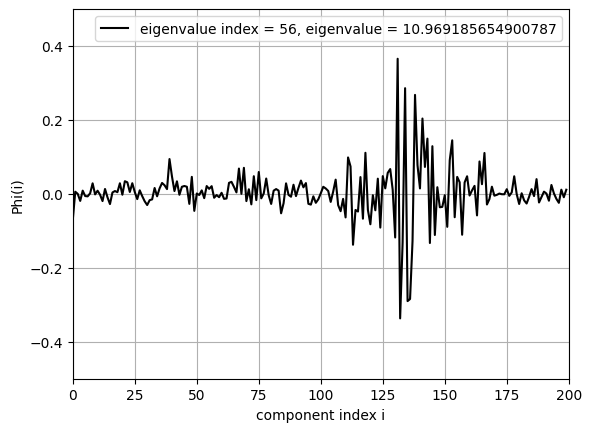

In [4]:
## Initial State ##
u_eq = np.full(num_nodes, compute_fixed_point()[0], dtype= float)
v_eq = np.full(num_nodes, compute_fixed_point()[1],  dtype= float)
u_0 = perturbed_array(u_eq)
v_0 = v_eq
y_0 = np.concatenate((u_0, v_0))
## Graph Definition ##
g = ba_graph()
critical_eig = compute_critical_eigenvalue()
[index, eig] = find_closest_eigenvalue(g, critical_eig)
fig, ax = plt.subplots()
plot_eigvec(g, index, ax)
laplacian_matrix= np.array(g.laplacian())
## Time Steps Definition ##
t_span = (0, 1000)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

In [5]:
sol = solve_ivp(rd_model, t_span, y_0, args=(laplacian_matrix,), t_eval=t_eval, method='RK45')

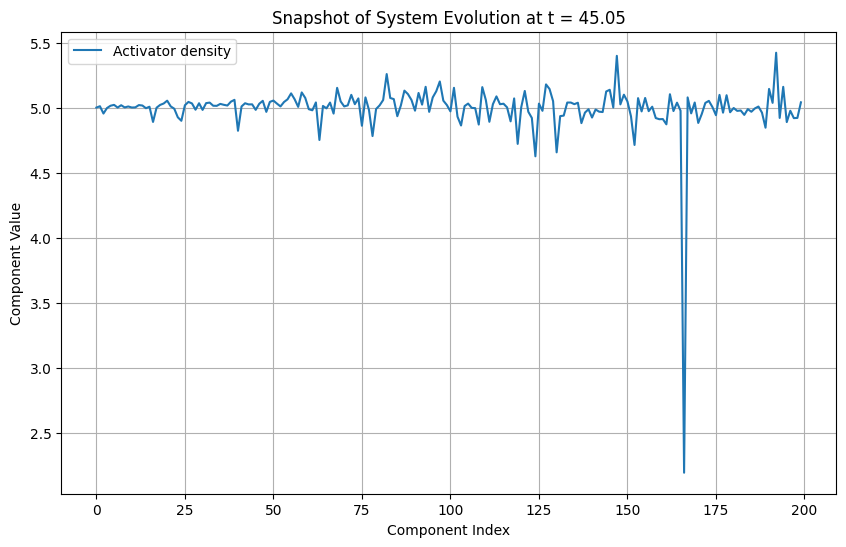

In [6]:
snapshot_time_index = 45
snapshot_time = sol.t[snapshot_time_index]
snapshot_y = sol.y[:, snapshot_time_index]

plt.figure(figsize=(10, 6))
plt.plot(range(num_nodes), snapshot_y[:num_nodes], label='Activator density')
plt.xlabel('Component Index')
plt.ylabel('Component Value')
plt.title(f'Snapshot of System Evolution at t = {snapshot_time:.2f}')
plt.legend()
plt.grid(True)
plt.show()

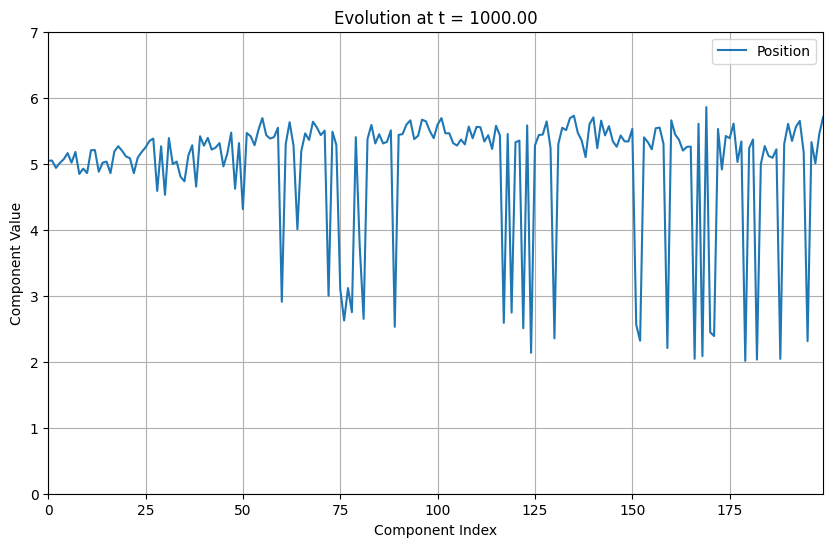

In [8]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot([], [], label='Position')
ax.set_xlim(0, num_nodes-1)
ax.set_ylim(0, 7)  # adjust this as needed based on your data
ax.set_xlabel('Component Index')
ax.set_ylabel('Component Value')
ax.set_title('Evolution')
ax.legend()
ax.grid(True)

# Initialization function for the animation
def init():
    line1.set_data([], [])
    return (line1,)

# Animation update function
def update(frame):
    line1.set_data(range(num_nodes), sol.y[:num_nodes, frame])
    ax.set_title(f'Evolution at t = {sol.t[frame]:.2f}')
    return (line1,)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(sol.t), init_func=init, blit=True)

# Save the animation as a video file
ani.save('prova.gif', writer=PillowWriter(fps=30))

plt.show()